In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
series = pd.read_excel('/content/sample_data/AL_WIND_07_12.xlsx',index_col="DateTime")
series.head()

,Air temperature(cel),Pressure (atm),Wind_speed (m/s),Wind_direction (deg),Power_generated_by_system (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [ ]:
series = series.dropna()
series = series[series > 0]
series.head()

,Air temperature(cel),Pressure (atm),Wind_speed (m/s),Wind_direction (deg),Power_generated_by_system (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229.0,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232.0,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236.0,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247.0,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256.0,27370.3


In [ ]:
series = series[:25000]

In [ ]:
# Cleaning Data
series['Power_generated_by_system (kW)'].replace(0, np.nan, inplace=True)
series['Power_generated_by_system (kW)'].fillna(method='ffill', inplace=True)
print(series)

                     Air temperature(cel)  Pressure (atm)  Wind_speed (m/s)  \
DateTime                                                                      
2007-01-01 00:00:00                10.926        0.979103             9.014   
2007-01-01 01:00:00                 9.919        0.979566             9.428   
2007-01-01 02:00:00                 8.567        0.979937             8.700   
2007-01-01 03:00:00                 7.877        0.980053             8.481   
2007-01-01 04:00:00                 7.259        0.979867             8.383   
...                                   ...             ...               ...   
2009-11-08 11:00:00                 5.840        0.988126             3.554   
2009-11-08 12:00:00                 5.549        0.988289             3.596   
2009-11-08 13:00:00                 8.072        0.988518             3.962   
2009-11-08 14:00:00                11.309        0.988750             3.953   
2009-11-08 15:00:00                14.356        0.9

In [ ]:
# initialize variables
batch_size_exp = 1
epoch_exp = 2
neurons_exp = 5
predict_values_exp = 48
lag_exp= 48

In [ ]:
# prompt: set above hypertunes which suitable for 10000 rows.
#[batch_size_exp = 1
# epoch_exp = 7
# neurons_exp = 10
# predict_values_exp = 48
# lag_exp=24]

batch_size_exp = 200
epoch_exp = 30
neurons_exp = 256
predict_values_exp = 48
lag_exp=24


In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
# scale train and test data to [-1, 1]
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
# fit an LSTM network to training data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [ ]:
print(series.columns)

Index(['Air temperature(cel)', 'Pressure (atm)', 'Wind_speed (m/s)',
       'Wind_direction (deg)', 'Power_generated_by_system (kW)'],
      dtype='object')


In [ ]:
# Drop all the features as we will not be having any in production
del series['Air temperature(cel)']
del series['Pressure (atm)']
del series['Wind_speed (m/s)']
del series['Wind_direction (deg)']

In [ ]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Power_generated_by_system (kW)
DateTime,
2009-11-08 01:00:00,21585.2
2009-11-08 02:00:00,23750.1
2009-11-08 03:00:00,20564.9
2009-11-08 04:00:00,18227.9
2009-11-08 05:00:00,13773.5


In [ ]:
# create a differenced series
from pandas import Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [ ]:
# Print the raw and differenced values
print("Raw values:", raw_values)
print("Differenced values:", diff_values)

Raw values: [[33688.1]
 [37261.9]
 [30502.9]
 ...
 [20564.9]
 [18227.9]
 [13773.5]]
Differenced values: 0          [3573.800000000003]
1                    [-6759.0]
2        [-2083.7000000000007]
3        [-1048.9000000000015]
4        [-1564.3999999999978]
                 ...          
24984     [1294.2999999999993]
24985      [2164.899999999998]
24986     [-3185.199999999997]
24987                [-2337.0]
24988    [-4454.4000000000015]
Length: 24989, dtype: object


In [ ]:
# frame a sequence as a supervised learning problem
from pandas import DataFrame
from pandas import concat
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [ ]:
# Print the supervised values
print("Supervised values:", supervised_values)

Supervised values: [[0 0 0 ... 0 0
  array([ 1.00000000e+00, -1.32132714e+00, -5.37000225e+00,  9.90000000e+01,
          1.13411838e+03])                                                  ]
 [array([ 1.00000000e+00, -1.32132714e+00, -5.37000225e+00,  9.90000000e+01,
          1.13411838e+03])
  0 0 ... 0 0
  array([-2.10000000e+01,  1.02481759e+00,  1.07193157e+01, -2.09000000e+02,
         -2.25317666e+03])                                                  ]
 [array([-2.10000000e+01,  1.02481759e+00,  1.07193157e+01, -2.09000000e+02,
         -2.25317666e+03])
  array([ 1.00000000e+00, -1.32132714e+00, -5.37000225e+00,  9.90000000e+01,
          1.13411838e+03])
  0 ... 0 0
  array([-4.00000000e+00, -1.02212126e+00, -1.17429522e+01,  5.70000000e+01,
          2.93850291e+03])                                                  ]
 ...
 [array([ 1.20000000e+01, -3.74395465e-01,  8.74986262e+00, -1.05000000e+02,
          3.16116342e+03])
  array([ 9.00000000e+00,  4.24667753e-02, -1.3725707

In [ ]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
import time

# Start timer for training
start_time_training = time.time()

In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

24941/24941 [==============================] - 81s 3ms/step - loss: 0.0140


In [ ]:
# End timer for training
end_time_training = time.time()

# Calculate training time
training_time = end_time_training - start_time_training
print("Training time:", training_time, "seconds")

Training time: 167.6301827430725 seconds


In [ ]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Start timer for prediction
start_time_prediction = time.time()

In [ ]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
test_pred = list()
 #Classify power level using CNN
def classify_power_level(prediction, low_threshold, high_threshold):
    if prediction < low_threshold:
        return 'low'
    elif prediction >= high_threshold:
        return 'high'
    else:
        return 'mid'

# Set your low and high thresholds
low_threshold = 10000
high_threshold = 35000

# Display Hour, Predicted, Expected, and Classified Power Level
expectations = np.array([])
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)  # make one-step forecast
    test_pred = np.array([yhat] + list(test_pred))  # Convert to numpy array for concatenation
    if i + 1 < len(test_scaled):
        end_idx = min(len(test_scaled[i+1]), len(test_pred))
        test_scaled[i + 1] = np.concatenate((test_pred[:end_idx], test_scaled[i + 1, end_idx:]), axis=0)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    predictions = np.append(predictions, yhat)  # Use np.append instead
    expected = raw_values[len(train) + i + 1]
    expectations = np.append(expectations, expected)  # Add expected value to the array
    classified_power_level = classify_power_level(yhat, low_threshold, high_threshold)
    #print('Hour=%d, Predicted=%f, Expected=%f, Classified=%s' % (i + 1, yhat, expected, classified_power_level))

1/1 [==============================] - 0s 25ms/step


In [ ]:
# End timer for prediction
end_time_prediction = time.time()

In [ ]:
for i in range(len(predictions)):
    predicted_power = predictions[i]
    expected_power = expectations[i]
    classified_power_level = classify_power_level(predicted_power, low_threshold, high_threshold)
    print('Hour=%d, Predicted=%f, Expected=%f, Classified=%s' % (i + 1, predicted_power, expected_power, classified_power_level))

# Calculate prediction time
prediction_time = end_time_prediction - start_time_prediction
print("Prediction time:", prediction_time, "seconds")

Hour=1, Predicted=1345.088038, Expected=1308.490000, Classified=low
Hour=2, Predicted=1655.611322, Expected=1599.080000, Classified=low
Hour=3, Predicted=2404.214140, Expected=1599.080000, Classified=low
Hour=4, Predicted=1307.318171, Expected=1599.080000, Classified=low
Hour=5, Predicted=20.648457, Expected=1599.080000, Classified=low
Hour=6, Predicted=924.251064, Expected=1599.080000, Classified=low
Hour=7, Predicted=1242.765185, Expected=1599.080000, Classified=low
Hour=8, Predicted=1987.817797, Expected=1599.080000, Classified=low
Hour=9, Predicted=2034.713019, Expected=1599.080000, Classified=low
Hour=10, Predicted=1768.668539, Expected=1599.080000, Classified=low
Hour=11, Predicted=1728.091815, Expected=1599.080000, Classified=low
Hour=12, Predicted=1507.234315, Expected=1599.080000, Classified=low
Hour=13, Predicted=1612.458570, Expected=1599.080000, Classified=low
Hour=14, Predicted=1425.981084, Expected=1599.080000, Classified=low
Hour=15, Predicted=1530.171530, Expected=1599.

In [ ]:
# prompt: show model evaluation accuracy

import numpy as np
# Calculate accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(expectations, predictions)
mse = mean_squared_error(expectations, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(expectations, predictions)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2:', r2)

MAE: 2508.9056903255873
MSE: 14686654.339118749
RMSE: 3832.317097934192
R2: 0.873532161762792


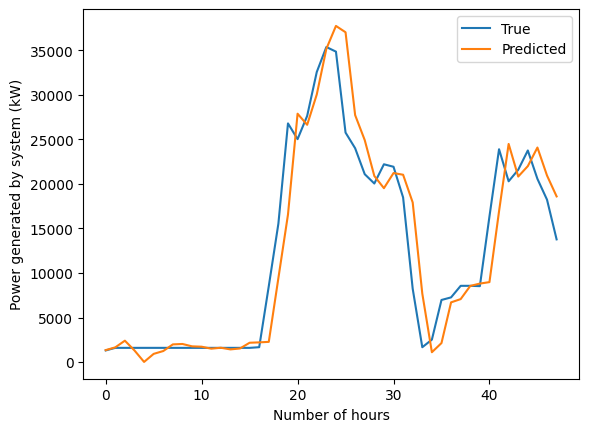

In [ ]:
from matplotlib import pyplot
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [ ]:
#[NO NEED TO RUN]

import time

# Start timer for training
start_time_training = time.time()

# Train the LSTM model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

# End timer for training
end_time_training = time.time()

# Calculate training time
training_time = end_time_training - start_time_training

# Start timer for prediction
start_time_prediction = time.time()

# Make predictions on the test set
predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    predictions.append(yhat)

# End timer for prediction
end_time_prediction = time.time()

# Calculate prediction time
prediction_time = end_time_prediction - start_time_prediction

# Print the training and prediction times
print("Training time:", training_time, "seconds")
print("Prediction time:", prediction_time, "seconds")


1/1 [==============================] - 0s 15ms/step
Training time: 22.384291410446167 seconds
Prediction time: 3.0598392486572266 seconds


In [ ]:
def calculate_time_complexity(nb_epoch, n):

    total_operations = n + nb_epoch * n + nb_epoch

    return total_operations

In [ ]:
# Assuming supervised_values, scale, and train_scaled are defined elsewhere
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
scaler, train_scaled, test_scaled = scale(train, test)

n = len(train_scaled)
nb_epoch = epoch_exp

time_complexity = calculate_time_complexity(nb_epoch, n)
print(f"Time complexity: O({time_complexity})")

Time complexity: O(5825)


In [ ]:
import numpy as np
model_string = str(lstm_model)
model_bytes = model_string.encode('utf-8')
model_size = len(model_bytes)

In [ ]:
# Get the size of the model in bytes
model_size = len(str(lstm_model).encode('utf-8'))

# Convert bytes to megabytes
model_size_mb = model_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.9f} MB")

Model size: 0.000061989 MB


In [ ]:
import math

# Get the size of the model in bytes
model_size = len(str(lstm_model).encode('utf-8'))

# Convert bytes to megabytes
model_size_mb = model_size / (1024 * 1024)

# Round the model size up to the nearest whole number
model_size_mb_rounded = math.ceil(model_size_mb)

# Print the rounded model size
print(f"Model size: {model_size_mb_rounded} MB")

Model size: 1 MB


In [ ]:
from keras.models import save_model

# Save the model
lstm_model.save('lstm_model.h5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Define the function to normalize input features
def normalize_features(features):
    # Assuming the original range for each feature was 0 to 100
    return features / 500.0

# Define the function to denormalize the prediction
def denormalize_prediction(prediction):
    # Assuming the denormalization range for power is 0 to 6000 kW
    return abs(prediction) * 4000000.0

# Load the trained LSTM model
lstm_model = load_model('/content/lstm_model.h5')

# Take user input for the four features
air_temperature = float(input("Enter air temperature (°C): "))
pressure = float(input("Enter pressure (atm): "))
wind_speed = float(input("Enter wind speed (m/s): "))
wind_direction = float(input("Enter wind direction (deg): "))

# Normalize the input features
input_features = np.array([[air_temperature, pressure, wind_speed, wind_direction]])
normalized_features = normalize_features(input_features)

# Expand the input features to match the expected shape (batch_size, 1, 24)
normalized_features_expanded = np.zeros((normalized_features.shape[0], 1, 48))
normalized_features_expanded[:, :, :4] = normalized_features

# Make a prediction using the LSTM model
prediction = lstm_model.predict(normalized_features_expanded)

# Denormalize the prediction
predicted_power = denormalize_prediction(prediction[0][0])

# Display the predicted power output
print("Predicted power generated by the system:", predicted_power, "kW")

Enter air temperature (°C): 7.259
Enter pressure (atm): 0.979867
Enter wind speed (m/s): 8.383
Enter wind direction (deg): 256
1/1 [==============================] - 0s 435ms/step
Predicted power generated by the system: 24460.85959672928 kW


In [ ]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.datasets import mnist
from keras.utils import to_categorical

# Load the trained LSTM model
from tensorflow.keras.models import load_model

def normalize_features(features):
    # Assuming the original range for each feature was 0 to 100
    return features / 500.0

# Define the function to denormalize the prediction
def denormalize_prediction(prediction):
    # Assuming the denormalization range for power is 0 to 6000 kW
    return abs(prediction) * 4000000.0
st.title(':blue[Wind power prediction using machine learning]')
st.image('/content/sample_data/windmills.jpg')

tab1, tab2, tab3 = st.tabs(["prediction", "about", "contact"])
with tab1:
# Load the pre-trained LSTM model
  model = load_model('/content/lstm_model.h5')
  st.title(':blue[LSTM Model Prediction]')
  st.write('Enter input values:')
# Add input fields for user input
  input1 = st.number_input(':red[AIR TEMPERATURE (c)]')
  input2 = st.number_input(':red[PRESSURE (atm)]')
  input3 = st.number_input(':red[WIND SPEED (m/s)]')
  input4 = st.number_input(':red[WIND DIRECTION (deg)]')
# Add more input fields as needed

  if st.button('Predict'):
    # Preprocess the input data (e.g., scaling)
      input_features = np.array([[input1, input2, input3, input4]])  # Adjust as needed
      normalized_features = normalize_features(input_features)

        # Expand the input features to match the expected shape (batch_size, 1, 24)
      normalized_features_expanded = np.zeros((normalized_features.shape[0], 1, 48))
      normalized_features_expanded[:, :, :4] = normalized_features
    # Make prediction
      prediction = model.predict(normalized_features_expanded)
      predicted_power = denormalize_prediction(prediction[0][0])
      st.write('Prediction:', predicted_power,'KW')

with tab2:
  st.title(":blue[About Windmill Power Prediction]")
  st.write("This web application predicts windmill power output using a combination of Convolutional Neural Network (CNN) and LSTM (Long Short-Term Memory) models.")

    # Overview of the project
  st.header("Project Overview",divider='rainbow')
  st.markdown("""
    Wind energy is an important renewable energy source, and accurate prediction of windmill power output is crucial for efficient energy production.
    This project leverages machine learning techniques, specifically a combination of CNN and LSTM models, to predict windmill power based on the following inputs:
    - Air temperature (celsius)
    - Wind Direction (in degrees)
    - Pressure (in hPa)
    - Wind Speed (in m/s)

    The CNN model extracts spatial patterns from the input features, and the LSTM model captures temporal dependencies to make accurate predictions.
    """)

    # About CNN and LSTM
  st.header("About CNN and LSTM",divider='rainbow')
  st.markdown("""
    - *Convolutional Neural Network (CNN):* CNNs are powerful deep learning models commonly used for image analysis. In this project, a CNN is used to extract spatial patterns from the input features. It learns to identify important spatial relationships in the data.

    - *Long Short-Term Memory (LSTM):* LSTM is a type of recurrent neural network (RNN) known for its ability to capture long-term dependencies in sequential data. Here, the LSTM model is used to learn temporal patterns and dependencies in the windmill data.

    By combining the strengths of CNN and LSTM, the model is able to effectively learn both spatial and temporal features, leading to more accurate predictions.
    """)

    # About Input Features
  st.header("Input Features",divider='rainbow')
  st.markdown("""
    The following are the input features used for windmill power prediction:
    - *Air temperature (celsius):* Temperature in the air.
    - *Wind Direction (degrees):* The direction from which the wind is blowing.
    - *Pressure (hPa):* Atmospheric pressure at the location.
    - *Wind Speed (m/s):* Speed of the wind.

    These features are crucial factors that influence windmill power generation, and the CNN-LSTM model uses them to make predictions.
    """)

    # Conclusion
  st.header("Conclusion",divider='rainbow')
  st.markdown("""
    This web application provides a user-friendly interface for predicting windmill power output using a combination of CNN and LSTM models.
    Users can input values for wind direction, pressure, and wind speed to get accurate predictions on power output.

    The CNN-LSTM model, trained on historical windmill data, allows for precise predictions by capturing both spatial and temporal patterns.
    Wind energy producers can utilize this tool to optimize their operations and improve efficiency in energy generation.
    """)

with tab3:
  st.title("Contact Information")
  st.write("If you have any questions or inquiries, please feel free to contact us.")
  st.header("Contact Details")
  st.markdown("""
      *Email:* [JNNCE@example.com](mailto:contact@example.com)
      *Phone:* +91 98323 83471
      *Address:*
      JNNCE,
      NAVULE,
      SHIVAMOGGA-577202
      """)

Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

34.27.220.250


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.27.220.250:8501

npx: installed 22 in 3.142s
your url is: https://thirty-shirts-enter.loca.lt
2024-05-26 17:48:39.782999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 17:48:39.783066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 17:48:39.784644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 17:48:41.459121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi